In [1]:
#Uncomment following lines if running in Google Colab
import os
if not os.path.exists("data/"):
  os.mkdir("data/")
! pip install -q 'gwosc==0.5.4'
! pip install -q 'gwpy==2.0.2'
! wget -O 'data/GW_noisedata-2.npy' 'https://drive.google.com/uc?export=download&id=1-TP16GA9Pe0lM6isKu9ByaGtqBIU9pns' 
! pip install -q 'PyCBC==1.18.0' 'lalsuite==6.82'

--2022-02-15 01:20:20--  https://drive.google.com/uc?export=download&id=1-TP16GA9Pe0lM6isKu9ByaGtqBIU9pns
Resolving drive.google.com (drive.google.com)... 108.177.125.100, 108.177.125.113, 108.177.125.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/prrqnautpn43vbfdq8cqmffcs9h1ka4v/1644888000000/14905133362869798257/*/1-TP16GA9Pe0lM6isKu9ByaGtqBIU9pns?e=download [following]
--2022-02-15 01:20:21--  https://doc-0g-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/prrqnautpn43vbfdq8cqmffcs9h1ka4v/1644888000000/14905133362869798257/*/1-TP16GA9Pe0lM6isKu9ByaGtqBIU9pns?e=download
Resolving doc-0g-2k-docs.googleusercontent.com (doc-0g-2k-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to doc-0g-2k-docs.googleusercontent.com (doc-0g-2k

In [2]:
#imports
import matplotlib.pyplot as plt
%matplotlib inline
from pycbc.waveform import get_td_waveform
from pycbc import frame
import pylab
import numpy
import pycbc
from pycbc.filter import highpass, matched_filter, resample_to_delta_t
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [3]:
#it is easier to have the data imported by pycbc
#use types.load_timeseries as the file is just an array
data = pycbc.types.load_timeseries("data/GW_noisedata-2.npy")
sample_rate = data.sample_rate
print("sample_rate = {} \nduration = {}".format(sample_rate,data.duration))

sample_rate = 4096.0 
duration = 256.0


sample_rate = 2048.0 
duration = 252.0


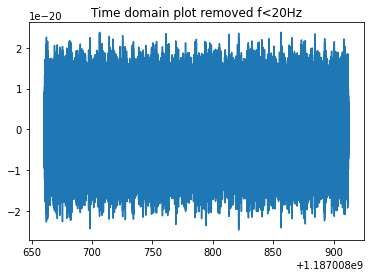

In [4]:
#removing frequencies lower than 20Hz
data = highpass(data,20)
data = resample_to_delta_t(data, 1.0/2048)

#remove possible data coruption due to highpassing and resampling
data = data.crop(2,2)
pylab.figure()
pylab.plot(data.sample_times,data)
pylab.title('Time domain plot removed f<20Hz')
sample_rate = data.sample_rate
duration = data.duration
print("sample_rate = {} \nduration = {}".format(sample_rate,duration))

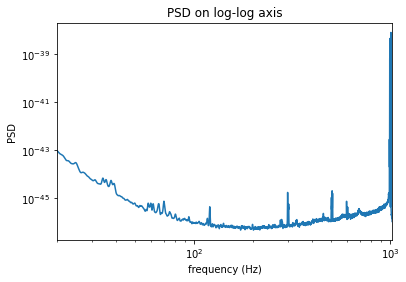

In [5]:
# estimating the PSD
# 3 second samples are chosen for the PSD
PSD = data.psd(2)
#interpolating the PSD to match our data
PSD = interpolate(PSD,data.delta_f)
PSD = inverse_spectrum_truncation(PSD, int(2 * data.sample_rate), low_frequency_cutoff=15)


#plot the PSD on log-log axis
pylab.figure()
pylab.plot(PSD.sample_frequencies,PSD)
pylab.xlim(20,sample_rate/2)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('frequency (Hz)')
pylab.ylabel('PSD')
pylab.title('PSD on log-log axis')
pylab.show()

the mean is  9.967087776160462e-05


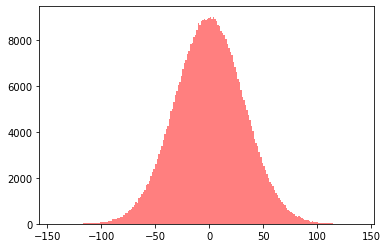

In [6]:
#we now have the PSD, so we can withen the data

data_whitened = (data.to_frequencyseries(PSD.delta_f) / PSD**0.5).to_timeseries()

# data_whitened = data.whiten(2,2)
data_whitened = data_whitened.crop(2,2)

#plot histogram
plt.hist(data_whitened, 200, facecolor='red', alpha=0.5)

#calculate mean of whitened data
mean = data_whitened.sum()/len(data_whitened)
print("the mean is ",mean)
#the mean is almost equal to zero

#the mean is so small that it might as well be equal to zero, the histogram shows that it is an gaussian distribution

In [7]:
#make wave functions for different masses and check if there is a signal in the data that matches it save values of detected signals in list
masses = [5,6,7,8,9,10]
distance = [1,10,100,500,1000]

signal = []
for d in distance:
  for m in masses:

        hp, hc = get_td_waveform(approximant="IMRPhenomD",
                              mass1=m,
                              mass2=m,
                              delta_t=data.delta_t,
                              distance = d,
                              f_lower=20)


        #resize to match the size of the data
        hp.resize(len(data))
        hc.resize(len(data))
        #in order to make the SNR time series to match the merger we need to shift the wave functions so that the merger in the wave functions occurs in the first data bin
        hp_shifted = hp.cyclic_time_shift(hp.start_time)
        hc_shifted = hc.cyclic_time_shift(hc.start_time)
        #project the wave function on detecter as if it was detected
        declination = 0.65
        right_ascension = 4.67
        polarization = 2.34
        wave = pycbc.detector.Detector('H1').project_wave(hp_shifted, hc_shifted,  right_ascension, declination, polarization)
        wave.resize(len(data))
        wave = wave.cyclic_time_shift(wave.start_time)

        #compute the SNR by using matched_filter
        snr_p = matched_filter(wave, data, psd=PSD, low_frequency_cutoff=20)

        #remove time corruption due to filtering
        snr_p = snr_p.crop(15,5)


        #peak in SNR
        peak = abs(snr_p).numpy().argmax()
        snrp = snr_p[peak]
        time = snr_p.sample_times[peak]
        if snrp >= 8:
          signal.append("{} solarmasses and {} Mpc distance detected at t={} with SNR={}".format(m,d,time,abs(snrp)))

          #plot the SNR
          pylab.figure(figsize=[10, 4])
          pylab.plot(snr_p.sample_times, abs(snr_p))

          pylab.ylabel('Signal-to-noise')
          pylab.xlabel('Time (s)')
          pylab.legend()
          pylab.title('SNR of mass = {} solarmasses and distance {}'.format(m,d))
          pylab.show()



In [8]:
if signal == []:
  print("No signal was detected")
else: 
  for sig in signal: 
    print(sig)

No signal was detected


In [9]:
#I wasn't able to detect a signal, though I tried many different combinations for the wave function
# I tried different approximators, spin no spin distances masses and projecting the wave function onto the detector
